In [40]:
%matplotlib inline

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K

In [39]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title("Learning curve", fontsize=24)
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [3]:
data = web.DataReader("^GSPC", "yahoo", '1950-01-01')
data['Adj Close'] = data['Adj Close'].apply(lambda x: float(x) if x!='null' else np.nan).fillna(method='ffill')

In [29]:
prices = data[['Adj Close']]
prices[-4:]

,Adj Close
Date,
2017-07-07,2425.179932
2017-07-10,2427.429932
2017-07-11,2425.530029
2017-07-12,2443.250000


In [5]:
#process input into windows of data and the future action

window_length = 252
future_return = 63

def subsequences(df, window):
    X = []
    Y = []
    index_original = []

    for idx, d in enumerate(df.index[window:]):
        try:
            train = df[df.index[idx]:df.index[idx+window-1]]
            train = ((train / train.mean())-1).as_matrix()
            reward_window = df[df.index[idx+window]:df.index[idx+window+future_return]]

            rets = (reward_window.ix[-1] / reward_window.ix[0]) - 1
            
            X.append(train)
            #1 if the market declines in the next 3 months, 0 if all is well
            Y.append(1 if rets['Adj Close'] < -0.1 else 0)
            index_original.append(df.index[idx+window-1])
        except Exception as e:
            pass
    
    return np.array(X), np.array(Y), index_original

X, Y, index_dates = subsequences(prices, window_length)

print X.shape, Y.shape

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


(16676, 252, 1) (16676,)


In [6]:
split = 10500

x_train, y_train = X[:split], Y[:split]
x_test, y_test = X[split:], Y[split:]

index_dates_train, index_dates_test = index_dates[:split], index_dates[split:]

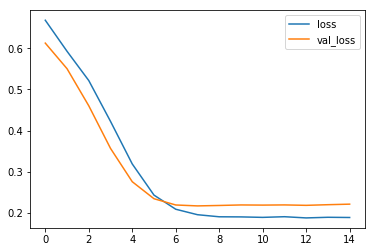

In [17]:
model = Sequential()
model.add(Conv1D(20, 63, activation='linear', padding='same', input_shape=(X[0].shape[0], len(prices.columns))))
model.add(Conv1D(20, 63, activation='linear'))

model.add(Dropout(0.5))

model.add(Flatten())
#model.add(LSTM(20))

model.add(Dense(50))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['binary_crossentropy'])

model.fit(x_train, y_train, epochs=15, batch_size=3200, verbose=0, validation_data=(x_test, y_test), callbacks=[plot_losses])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=10,window=21,center=False).mean()
  


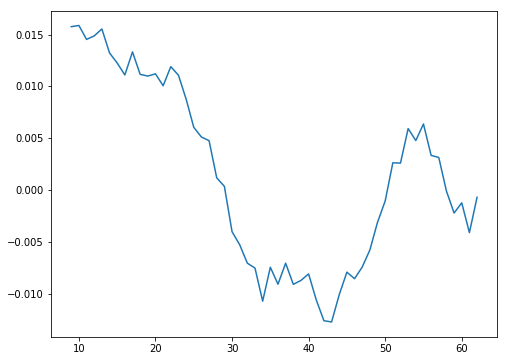

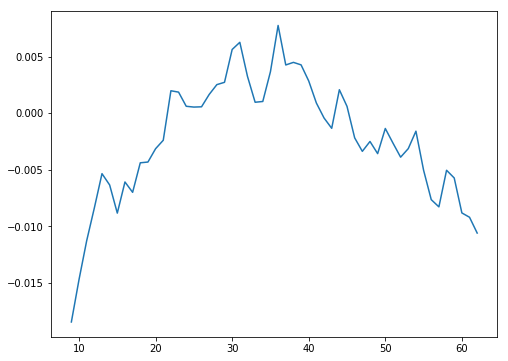

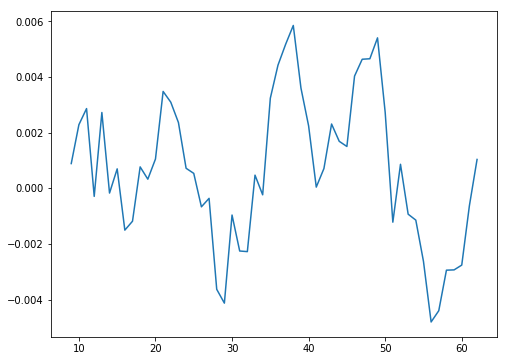

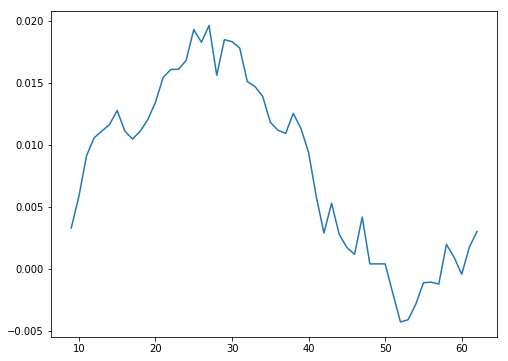

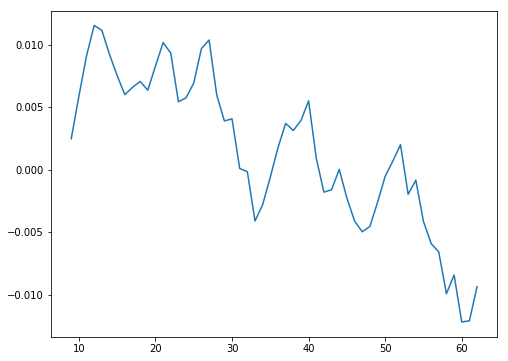

In [38]:
#visualize convolutioal filters
for filt_index in range(5):
    filt = model.layers[1].get_weights()[0][:,0][:,filt_index]

    plt.figure(figsize=(8,6))
    plt.plot(pd.rolling_mean(pd.Series(filt),21, min_periods=10))
    plt.show()

In [19]:
results = prices.ix[index_dates]
results['model'] = model.predict(X)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21,center=False).max()
  


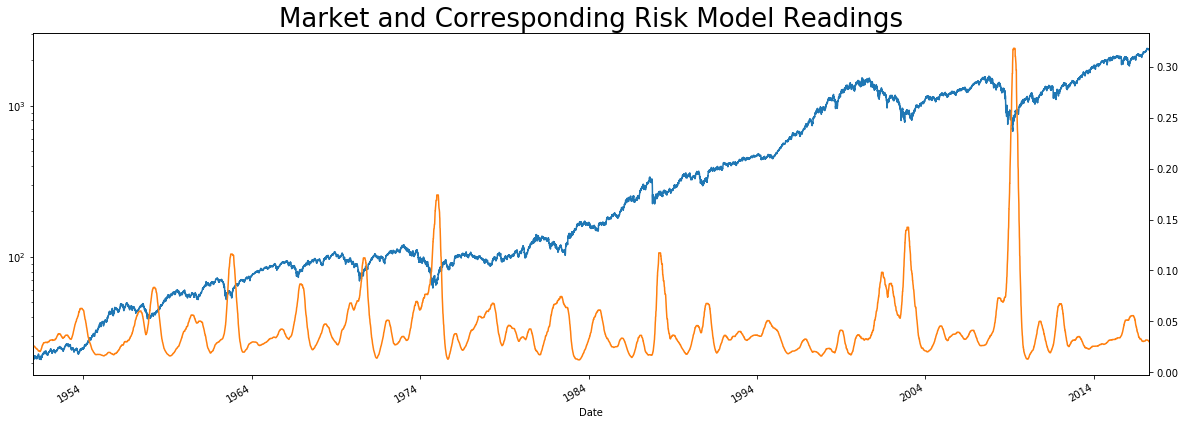

In [41]:
results[results.columns[0]].plot(figsize=(20,7), logy=True)
pd.rolling_max(results[results.columns[1]], 21).plot(secondary_y=True)
plt.title('Market and Corresponding Risk Model Readings', fontsize=26)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=21,center=False).max()
  """Entry point for launching an IPython kernel.


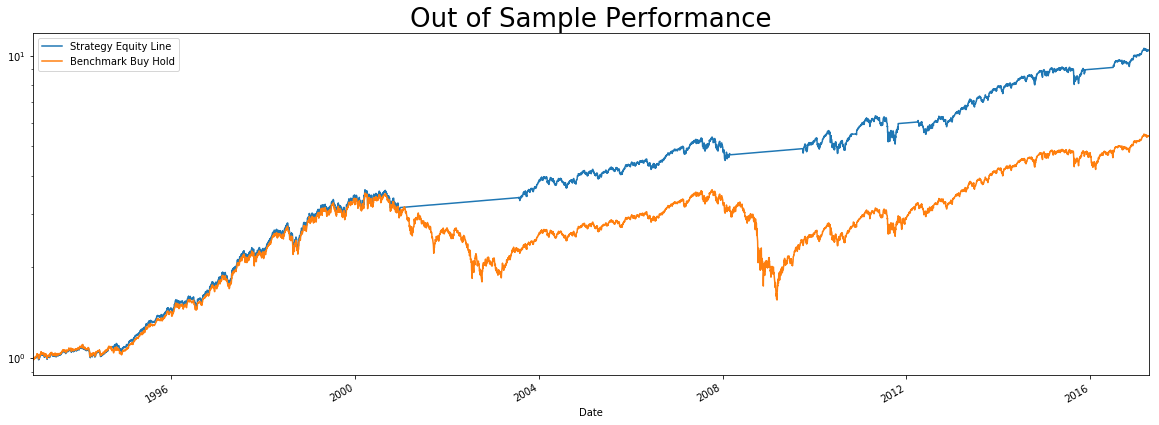

In [37]:
#get highest value within each month
signals = pd.rolling_max(results['model'], 21).apply(lambda x: 1.0 if x < 0.05 else 0.0)['1993-01-01':]

#get signal at end of month
signals = signals.resample('BM').last().reindex_like(signals).fillna(method='ffill')

el = ((results[results.columns[0]].pct_change(1).reindex_like(signals) * signals))
#bond return when out of stocks
el[el==0] = 1.03 ** (1 / float(252)) - 1
el = (el + 1).cumprod()
bench = ((results[results.columns[0]].pct_change(1).reindex_like(signals) * 1)+1).cumprod()

perf = pd.DataFrame()
perf['Strategy Equity Line'] = el
perf['Benchmark Buy Hold'] = bench

perf.plot(figsize=(20,7), logy=True)
plt.title('Out of Sample Performance', fontsize=26)

In [16]:
model.save('model_1.h5')